In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('../../data/df_6H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (35064, 39)

Number of unique patients: 5844

SepsisLabel class counts:
 SepsisLabel
1.0    17532
0.0    17532
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2922
1.0    2922
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

# Split

In [3]:
train_df, test_df = split_train_test_data_v2(data) 

# Extraction des séquences et normalisation

In [4]:
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

functions_and_imports.ipynb:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - sequences (list): Une liste de tableaux numpy représentant les séquences de caractéristiques.\n",
functions_and_imports.ipynb:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - labels (list): Une liste d'étiquettes associées à chaque séquence.\n",


In [7]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((4675, 6, 35), (4675,), (1169, 6, 35), (1169,))

# Modèle

In [96]:
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.

    Args:
    - X_train: Séquences d'entraînement (padded).
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation (padded).
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle LSTM entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(64),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history




# Entrainement 

In [61]:
from keras.regularizers import l2

In [97]:
input_shape = (6, 35)  # time steps, features
model_1, history_1 = build_and_train_lstm_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5039 - loss: 0.6927 - val_accuracy: 0.6664 - val_loss: 0.6883
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5707 - loss: 0.6887 - val_accuracy: 0.6553 - val_loss: 0.6828
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6297 - loss: 0.6817 - val_accuracy: 0.6818 - val_loss: 0.6660
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6503 - loss: 0.6677 - val_accuracy: 0.7134 - val_loss: 0.6295
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6852 - loss: 0.6289 - val_accuracy: 0.7613 - val_loss: 0.5501
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7630 - loss: 0.5451 - val_accuracy: 0.7759 - val_loss: 0.4763
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7937 - loss: 0.4737 - val_accuracy: 0.8144 - val_loss: 0.4300
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8143 - loss: 0.4354 - val_accuracy: 0

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8613 - loss: 0.3313 - val_accuracy: 0.8811 - val_loss: 0.3203
Epoch 52/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8683 - loss: 0.3236 - val_accuracy: 0.8777 - val_loss: 0.3217
Epoch 53/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8680 - loss: 0.3209 - val_accuracy: 0.8811 - val_loss: 0.3201
Epoch 54/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8681 - loss: 0.3184 - val_accuracy: 0.8674 - val_loss: 0.3330
Epoch 55/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8591 - loss: 0.3254 - val_accuracy: 0.8845 - val_loss: 0.3177
Epoch 56/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8664 - loss: 0.3299 - val_accuracy: 0.8743 - val_loss: 0.3225
Epoch 57/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8712 - loss: 0.3150 - val_accuracy: 0.8802 - val_loss: 0.3191
Epoch 58/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8631 - loss: 0.3187 - val_accuracy: 0.8708 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8771 - loss: 0.2844 - val_accuracy: 0.8888 - val_loss: 0.2998
Epoch 102/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8745 - loss: 0.2933 - val_accuracy: 0.8871 - val_loss: 0.3055
Epoch 103/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8787 - loss: 0.2831 - val_accuracy: 0.8896 - val_loss: 0.2927
Epoch 104/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8732 - loss: 0.3000 - val_accuracy: 0.8760 - val_loss: 0.3155
Epoch 105/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8601 - loss: 0.3129 - val_accuracy: 0.8862 - val_loss: 0.2928
Epoch 106/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8759 - loss: 0.2873 - val_accuracy: 0.8871 - val_loss: 0.2974
Epoch 107/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8723 - loss: 0.2904 - val_accuracy: 0.8922 - val_loss: 0.2942
Epoch 108/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8739 - loss: 0.2890 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8824 - loss: 0.2944 - val_accuracy: 0.8956 - val_loss: 0.2750
Epoch 152/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8848 - loss: 0.2671 - val_accuracy: 0.8965 - val_loss: 0.2763
Epoch 153/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8841 - loss: 0.2719 - val_accuracy: 0.8871 - val_loss: 0.2860
Epoch 154/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8854 - loss: 0.2755 - val_accuracy: 0.8871 - val_loss: 0.2840
Epoch 155/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8817 - loss: 0.2833 - val_accuracy: 0.8973 - val_loss: 0.2748
Epoch 156/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8870 - loss: 0.2589 - val_accuracy: 0.8939 - val_loss: 0.2775
Epoch 157/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8871 - loss: 0.2725 - val_accuracy: 0.8956 - val_loss: 0.2718
Epoch 158/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8816 - loss: 0.2777 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8935 - loss: 0.2447 - val_accuracy: 0.8999 - val_loss: 0.2645
Epoch 202/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8910 - loss: 0.2489 - val_accuracy: 0.9008 - val_loss: 0.2635
Epoch 203/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8860 - loss: 0.2637 - val_accuracy: 0.8956 - val_loss: 0.2658
Epoch 204/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8951 - loss: 0.2548 - val_accuracy: 0.8922 - val_loss: 0.2706
Epoch 205/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8857 - loss: 0.2637 - val_accuracy: 0.8931 - val_loss: 0.2709
Epoch 206/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8784 - loss: 0.2768 - val_accuracy: 0.8837 - val_loss: 0.2853
Epoch 207/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8922 - loss: 0.2573 - val_accuracy: 0.8914 - val_loss: 0.2709
Epoch 208/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8829 - loss: 0.2747 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8919 - loss: 0.2496 - val_accuracy: 0.8999 - val_loss: 0.2575
Epoch 252/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9008 - loss: 0.2434 - val_accuracy: 0.8982 - val_loss: 0.2585
Epoch 253/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8919 - loss: 0.2458 - val_accuracy: 0.8982 - val_loss: 0.2653
Epoch 254/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8972 - loss: 0.2422 - val_accuracy: 0.8982 - val_loss: 0.2594
Epoch 255/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8994 - loss: 0.2435 - val_accuracy: 0.8914 - val_loss: 0.2659
Epoch 256/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8934 - loss: 0.2530 - val_accuracy: 0.8999 - val_loss: 0.2587
Epoch 257/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8996 - loss: 0.2395 - val_accuracy: 0.9008 - val_loss: 0.2592
Epoch 258/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8934 - loss: 0.2399 - val_accuracy: 

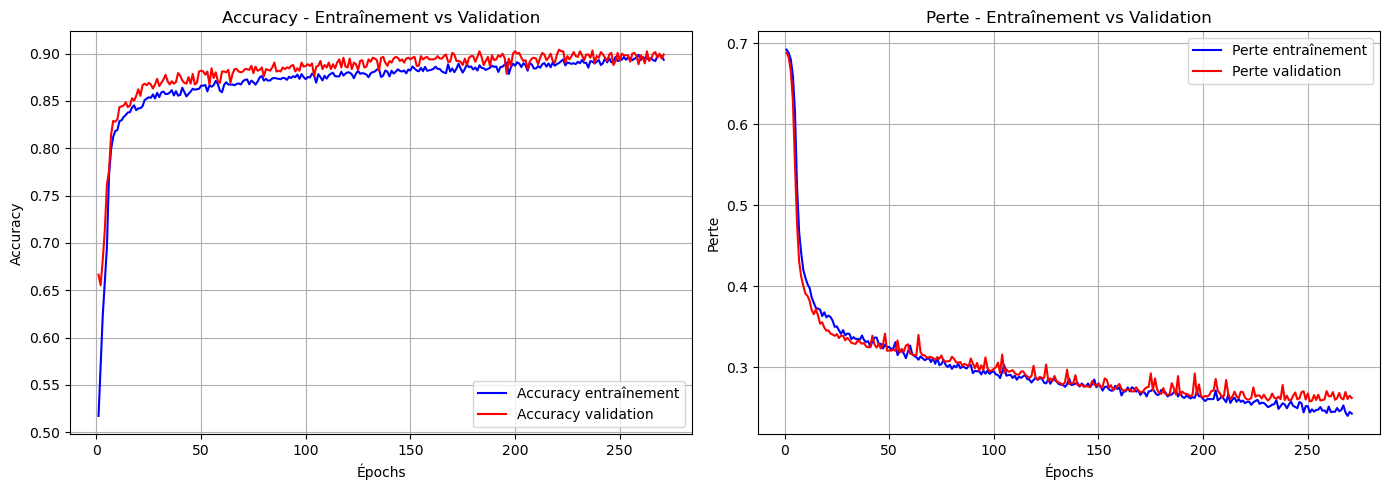

In [98]:
plot_training_history(history_1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Accuracy: 0.8999
Precision: 0.8911
Recall: 0.9164
F1-Score: 0.9035
AUROC: 0.9588


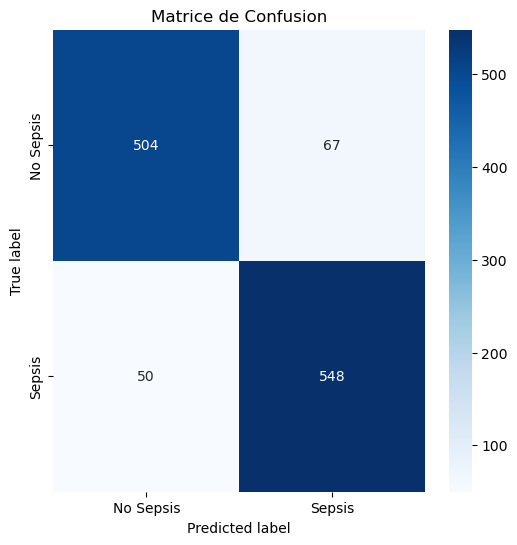

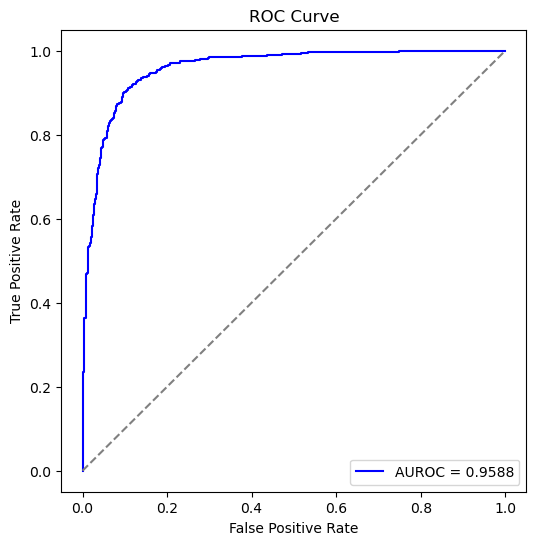

In [99]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_1, normalize_sequences_test, labels_test)